In [ ]:
#!pip install emoji

In [173]:
import pickle

import time
import pandas as pd
import numpy as np
import re
import spacy
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.help import upenn_tagset
from sklearn.decomposition import PCA,TruncatedSVD,NMF
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize,MWETokenizer

from gensim import corpora, models, matutils
from corextopic import corextopic as ct
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scattertext as st
import random

In [178]:
df_tweet_copy= pd.read_pickle('df_tweet_clean.pkl')

df_tweet_copy.columns

Index(['author_id', 'username', 'author_followers', 'author_followings',
       'author_tweets', 'author_description', 'author_location', 'text',
       'created_at', 'retweets', 'replies', 'likes', 'quote_count',
       'description_corpus', '@list', 'tweet_corpus', 'sentiment_score',
       'attitude'],
      dtype='object')

In [179]:
df_tweet = df_tweet_copy.copy()
df_tweet.shape

(17563, 18)

In [180]:
df_tweet = df_tweet[df_tweet["author_description"].str.contains(' ')==True]
df_tweet.index = range(df_tweet.shape[0])
df_tweet.shape

(13345, 18)

In [181]:
import emoji
# emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags=re.UNICODE)
                          
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)   



tweet_corpus = []
for i,text in enumerate(df_tweet.tweet_corpus):
    text = remove_emoji(text)
    text = re.sub('robert',"",text)
    text = re.sub('via'," ",text)
    text = re.sub('[%s+]' % '!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~', ' ',text) #delete pucuration
    text = re.sub('  '," ",text)
    text = text.replace('/\s\s+/g' ,' ')
    tweet_corpus.append(text)
                          

In [182]:
df_tweet.tweet_corpus =tweet_corpus
df_tweet.drop_duplicates(subset=['tweet_corpus'],inplace= True,ignore_index= True)
df_tweet.shape

(13157, 18)

In [183]:
with open("df_tweet_fot_TM.pkl",'wb') as file:
    pickle.dump(df_tweet,file)

In [184]:
df_tweet = pd.read_pickle('df_tweet_fot_TM.pkl')
df_tweet.shape

(13157, 18)

### Vectorization for tweet docs

#### Count vectorize

In [185]:
cv = CountVectorizer(max_df=0.5, min_df=5, stop_words='english',ngram_range=(1, 2))
doc_term_matrix_cv = cv.fit_transform(df_tweet.tweet_corpus)
doc_term_matrix_cv.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [186]:
doc_term_df_cv = pd.DataFrame(doc_term_matrix_cv.toarray(),columns=cv.get_feature_names(),index =df_tweet.index )
doc_term_df_cv.shape

(13157, 6819)

In [187]:
cv.get_feature_names().count('vaccine')

1

##### TFIDF vectorizer

In [188]:
tfidf = TfidfVectorizer( max_df=0.5, min_df=4, stop_words='english',ngram_range=(1, 2))
doc_term_matrix_tfidf = tfidf.fit_transform(df_tweet.tweet_corpus)
doc_term_matrix_tfidf.toarray()
doc_term_matrix_tfidf.shape

(13157, 8687)

In [189]:
#doc_term_df_tfidf= pd.DataFrame(doc_term_matrix_tfidf.toarray(),columns=tfidf.get_feature_names(),index =df_tweet.tweet_corpus)
doc_term_df_tfidf= pd.DataFrame(doc_term_matrix_tfidf.toarray(),columns=tfidf.get_feature_names(),index =df_tweet.index )
doc_term_df_tfidf.drop_duplicates(inplace=True)
doc_term_df_tfidf.shape

(12423, 8687)

In [190]:
drop_index = np.setdiff1d(np.array(df_tweet.index),np.array(doc_term_df_tfidf.index))
df_tweet = df_tweet.drop(index = drop_index)
df_tweet.shape

(12423, 18)

In [191]:
# for i in drop_index:
#     print(i,": ",df_tweet.loc[i,'tweet_corpus'])

In [192]:
tfidf = TfidfVectorizer( max_df=0.5, min_df=5, stop_words='english',ngram_range=(1, 2))
doc_term_matrix_tfidf = tfidf.fit_transform(df_tweet.tweet_corpus)
doc_term_matrix_tfidf.toarray()
doc_term_matrix_tfidf.shape

(12423, 6592)

In [193]:
doc_term_df_tfidf= pd.DataFrame(doc_term_matrix_tfidf.toarray(),columns=tfidf.get_feature_names(),index =df_tweet.index )
doc_term_df_tfidf.head()
doc_term_df_tfidf.shape

(12423, 6592)

In [194]:
from sklearn.metrics.pairwise import cosine_distances

In [195]:
distance = cosine_distances(doc_term_matrix_tfidf)

### Recommendations According user's tweet

In [196]:
svd= TruncatedSVD(n_components=60)
tweet_topic_matrix_svd= svd.fit_transform(doc_term_df_tfidf)
tweet_topic_svd_df = pd.DataFrame(tweet_topic_matrix_svd,index = df_tweet.index)
tweet_topic_svd_df.shape

(12423, 60)

In [204]:
def user_recommend():
    user_id = input("PLEASE INPUT USER INDEX ID FOR RECOMMENDATION:")
    rec_number = input("PLEASE INPUT RECOMMENDATION NUMBERS: (1-5)")
    dig_index = list(df_tweet.author_id).index(int(user_id))
    index_name = df_tweet.index[dig_index]
    print(dig_index, index_name)
    print(f"User name: \033[1m{df_tweet.loc[index_name,'username']} \033[0m :" )
    
    print ("User's tweet : \n", df_tweet.loc[index_name,'tweet_corpus'])
    
    id_array = np.array(tweet_topic_svd_df.loc[index_name,:]).reshape(1, -1)
    dist = pairwise_distances(id_array,tweet_topic_matrix_svd)
    recommend_id = [df_tweet.index[i] for i in dist.argsort()[0][1:int(rec_number)+1]]
    print("\n ","*"*20,"The similar opion user's tweet :","*"*20," \n")
    for id_ in recommend_id:
        print(f"\n User \033[1m{df_tweet.username[id_]} \033[0m :\n",df_tweet.tweet_corpus[id_ ])


In [205]:
# df_tweet.author_id[:10]
# 0             1316931193
# 1              867042174
# 2    1377753958933000192
# 3               17266544
# 4              975463213
# 5             4879248443
# 6              566215695
# 7               19514406
# 8    1357758153329315841
# 9    1314638403300925440
# Name: author_id, dtype: int64

In [206]:
user_recommend()

PLEASE INPUT USER INDEX ID FOR RECOMMENDATION:975463213
PLEASE INPUT RECOMMENDATION NUMBERS: (1-5)4
4 4
User name: susan_carkin  :
User's tweet : 
  yes dr malone is solid brilliant deeply informed and capable of explaining complex science—without talking down to people 

  ******************** The similar opion user's tweet : ********************  


 User Grimtina  :
  so some people make money from the situation this always happens greed is human nature the vaccines had to be accelerated because they were needed now so for him to have an issue with it is weird the rest is science politics 

 User giorgioua  :
  it cancelled dr malone a world leading immunologist the guy has been at the forefront of combatting infectious disease since the aids outbreak absolute insanity the people that are pro science cancel science when it doesn’t suit them 

 User jackruffin1  :
 we should be applauding katalin karikó drew weissman sarah gilbert  malone and the many others who have led the scientif

###  Vectorization for user discription docs

In [207]:
cv_au_description = CountVectorizer(max_df=.5, min_df= 4, stop_words='english',ngram_range=(1, 2))
description_term_matrix_cv = cv_au_description.fit_transform(df_tweet.description_corpus)

description_term_df_cv = pd.DataFrame(description_term_matrix_cv.toarray(),
                                      columns=cv_au_description.get_feature_names(),index =df_tweet.index )
description_term_df_cv.shape

(12423, 8546)

In [208]:
tfidf_au_description = TfidfVectorizer(max_df=0.5, min_df=4, stop_words='english',ngram_range=(1, 2))
description_term_matrix_tfidf = tfidf_au_description.fit_transform(df_tweet.description_corpus)

description_term_df_tfidf = pd.DataFrame(description_term_matrix_tfidf.toarray(),
                                      columns=tfidf_au_description.get_feature_names(),index =df_tweet.index )
description_term_df_tfidf.shape

(12423, 8546)

###  Topic Modeling On User Descriptions

In [354]:
def display_topics(model, feature_names, no_top_words, topic_names = None):
    topic_top_words = []
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("Topic ", ix )
        else:
            print("Topic: ", topic_names[ix])
        top_words =(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print(top_words,"\n")
        topic_top_words.append(top_words)
    return model, feature_names, no_top_words,topic_top_words

In [211]:
# au_description_topic_num =10
# lsa_au_description = TruncatedSVD(au_description_topic_num)
# lsa_au_description.fit(description_term_matrix_tfidf)
# output = display_topics(lsa_au_description, tfidf_au_description.get_feature_names(), 10)

#### NMF Top Modeling For User Descriptions

In [212]:
from collections import Counter

In [276]:
print(description_term_matrix_tfidf.shape)
desc_n_components = 12
nmf_au_description = NMF(n_components =desc_n_components)
des_topics_matrix = nmf_au_description.fit_transform(description_term_matrix_tfidf)


(12423, 8546)

Topic  0
conservative, christian, trump, patriot, mom, america, wife, proud, american, supporter, maga, christian conservative, conservative christian, trump supporter, mother, president, retired, lover, jesus, won 


Topic  1
just, guy, just guy, trying, just like, just trying, special, want, just banter, banter, make, person, simple, just want, stand, makes, just average, news, trying make, average 


Topic  2
truth, seeker, truth seeker, seeker truth, set free, set, truth set, truth truth, justice, speak, hunter, does, patriot, speak truth, truth hunter, seeker patriot, seeking, like truth, lies, truth justice 


Topic  3
god, family, country, god family, family country, love god, god country, bless, god bless, america, country family, bless america, loves, man, grace, lord, right, friends, patriot, family friends 


Topic  4
gettr, gab, parler, follow, telegram, twitter, gettr gab, username, follow gettr, gab gettr, gettr username, pronouns, gettr parler, retired, ha

In [357]:
output_des = display_topics(nmf_au_description, tfidf_au_description.get_feature_names(), 20)

Topic  0
conservative, christian, trump, patriot, mom, america, wife, proud, american, supporter, maga, christian conservative, conservative christian, trump supporter, mother, president, retired, lover, jesus, won 

Topic  1
just, guy, just guy, trying, just like, just trying, special, want, just banter, banter, make, person, simple, just want, stand, makes, just average, news, trying make, average 

Topic  2
truth, seeker, truth seeker, seeker truth, set free, set, truth set, truth truth, justice, speak, hunter, does, patriot, speak truth, truth hunter, seeker patriot, seeking, like truth, lies, truth justice 

Topic  3
god, family, country, god family, family country, love god, god country, bless, god bless, america, country family, bless america, loves, man, grace, lord, right, friends, patriot, family friends 

Topic  4
gettr, gab, parler, follow, telegram, twitter, gettr gab, username, follow gettr, gab gettr, gettr username, pronouns, gettr parler, retired, handle, moving gettr,

In [296]:
# descrip_topics_list = ['platform_sensorship',
#                  'new_politics_bigtech',
#                  'magats_girlinfj',
#                  'religious_patriot',
#                  'notranshumanism_novaxpassort',
#                  'life_clouds',
#                  'truth_freedom',
#                       "america"]


# descrip_topics_list = ['conservative_christian_trump',
#                         'just_guy_someone',
#                          'truthseeker',
#                          'father_husband_identity',
#                         'gettr_gab_parler_other_platform',
#                         'jersey_girlinfj_no_dms_no magats',
#                          'pro_anti_something',
#                          'dont_know_dont_do_something',
#                          'free_speech_thinker',
#                          'love_something',
#                         'about_follwing',
#                          'what_people_like_and_about_time',
#                          'god_family_country']

# descrip_topics_list =["_".join(topic.split(",")[:3]) for topic in output_des[3]]
# descrip_topics_list = ["".join(topic.split(" ")) for topic in descrip_topics_list]
# descrip_topics_list

descrip_topics_list = ['conservative_christian_trump',
                        'just_guy_someone',
                         'truthseeker',
                         'god_family_country',
                         'gettr_gab_parler_other_platform',
                         'jersey_girlinfj_no_dms_no magats',
                         'pro_anti_something',
                        'father_husband_identity',
                        'free_speech_thinker',
                         'love_something',
                         'do/dont_follow_don/do_somthing',
                         'what_people_like_and_about_time',
                         ]

In [297]:
descrip_topic_df_nmf = pd.DataFrame(des_topics_matrix,columns= descrip_topics_list,
                                    index = description_term_df_tfidf.index)
descrip_topic_df_nmf

,conservative_christian_trump,just_guy_someone,truthseeker,god_family_country,gettr_gab_parler_other_platform,jersey_girlinfj_no_dms_no magats,pro_anti_something,father_husband_identity,free_speech_thinker,love_something,do/dont_follow_don/do_somthing,what_people_like_and_about_time
0,0.000000,0.000000,0.000000,0.000258,0.000000,0.000000,0.002226,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000238,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057365,0.000000,0.008161,0.045998
2,0.001646,0.001592,0.000000,0.000000,0.000000,0.000000,0.003298,0.000000,0.003775,0.000000,0.001997,0.008930
3,0.001215,0.000000,0.000645,0.000000,0.000000,0.000199,0.000091,0.002982,0.001074,0.000576,0.000000,0.005560
4,0.006874,0.000000,0.000000,0.000000,0.001731,0.000000,0.004066,0.000157,0.000467,0.002458,0.000080,0.004940
...,...,...,...,...,...,...,...,...,...,...,...,...
13152,0.000000,0.000000,0.001885,0.000000,0.000000,0.000000,0.009909,0.001582,0.000000,0.008569,0.000000,0.025546
13153,0.000000,0.000000,0.096886,0.000000,0.000771,0.000000,0.000000,0.000177,0.000000,0.000000,0.000000,0.000000
13154,0.000000,0.000000,0.000000,0.000000,0.003222,0.000000,0.000000,0.011754,0.000000,0.001850,0.000251,0.057537
13155,0.001404,0.000259,0.004111,0.000000,0.000000,0.000000,0.005003,0.016947,0.001412,0.002676,0.000000,0.004971


Text(0.5, 1.0, 'Descprition topic numbers')

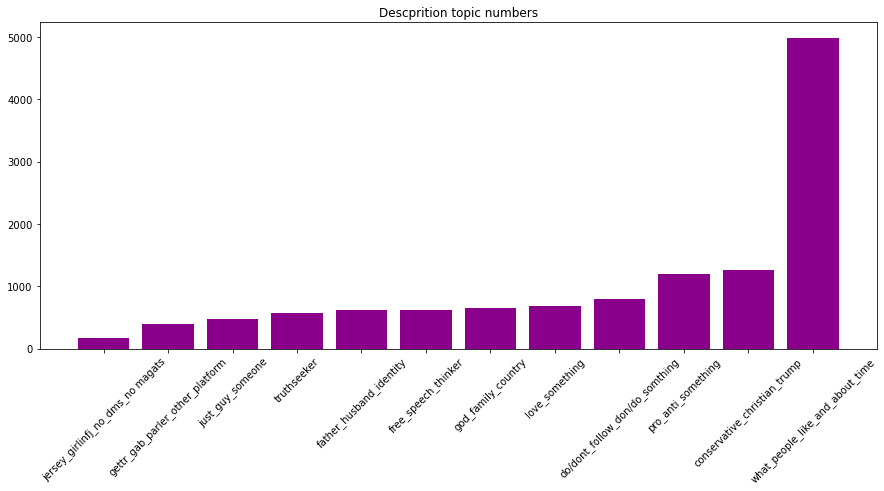

In [366]:
descrip_topic_array = np.argmax(des_topics_matrix,axis=1)
descrip_topic_dic  = Counter(descrip_topic_array)

descrip_topic_dic = sorted(descrip_topic_dic.items(), key=lambda x:x[1],reverse = False)
descrip_topic_dic = dict(descrip_topic_dic)

plt.figure(figsize= (15,6))
plt.bar(range(len(descrip_topic_dic.keys())),descrip_topic_dic.values(),
        tick_label =np.array(descrip_topics_list)[list(descrip_topic_dic.keys())], color = 'darkmagenta' )
plt.xticks(rotation = 45)
plt.title("Descprition topic numbers")

In [299]:
# print sample descriptions for each topics
df_user_topic_print = pd.DataFrame([df_tweet.description_corpus.values,descrip_topic_array,np.array(descrip_topics_list)[descrip_topic_array]]).transpose()
df_user_topic_print.columns = ['description','descpt_topic_number','descpt_topic']
df_user_topic_print.index = description_term_df_tfidf.index
df_user_topic_print.tail(5)


,description,descpt_topic_number,descpt_topic
13152,betram gilfoyle + sheldon cooper + jake peralt...,11,what_people_like_and_about_time
13153,"host, the naked truth report",2,truthseeker
13154,i'm usually a a foul mouthed viking fan and ta...,11,what_people_like_and_about_time
13155,dad and dedicated youth baseball coach! mounta...,7,father_husband_identity
13156,bill mcintosh valuetainment booker biggest int...,11,what_people_like_and_about_time


In [375]:
print_n =2
last_n = 10
for i in descrip_topic_dic.keys():
    topic = descrip_topic_df_nmf.columns[i]
    print(f'Topic number {i} :\033[1m{topic}\033[0m',)
    print(f"Top words are {output_des[3][i]}")
    for i,index in enumerate(descrip_topic_df_nmf[topic].argsort()[-last_n:-print_n- last_n:-1]):
        print(i,":",df_tweet.description_corpus.iloc[index])
    print(" "*10,"*"*88)
    

Topic number 5 :jersey_girlinfj_no_dms_no magats
Top words are proud, dms, jersey girlinfj, proud jersey, magats, girlinfj, girlinfj dms, dms magats, jersey, proud american, american, proud father, proud conservative, trains, canadian, proud supporter, awake proud, irish awake, proud member, member
0 : proud jersey girlinfj no dms; no magats
1 : proud jersey girlinfj no dms; no magats
           ****************************************************************************************
Topic number 4 :gettr_gab_parler_other_platform
Top words are gettr, gab, parler, follow, telegram, twitter, gettr gab, username, follow gettr, gab gettr, gettr username, pronouns, gettr parler, retired, handle, moving gettr, parler gettr, moving, politically, shots
0 : gettr: trish50
1 : gettr jenna70101 
           ****************************************************************************************
Topic number 1 :just_guy_someone
Top words are just, guy, just guy, trying, just like, just trying, spec

In [369]:
for i in descrip_topic_dic.keys():
    df_temp = df_user_topic_print[df_user_topic_print.descpt_topic_number ==i]
    print(f'Topic number {i}:  \033[1m{descrip_topics_list[i]}\033[0m ')
    print(f"Top words are : {output_des[3][i]} \n")
    

    x = random.sample(df_temp.description.to_list(),min(5,len(df_temp)))
    for j,des in enumerate(x):
        print(f"{j}:",des)
    print(" "*15,"*"*88,'')
    


Topic number 5:  jersey_girlinfj_no_dms_no magats 
Top words are : proud, dms, jersey girlinfj, proud jersey, magats, girlinfj, girlinfj dms, dms magats, jersey, proud american, american, proud father, proud conservative, trains, canadian, proud supporter, awake proud, irish awake, proud member, member 

0: proud indigenous canadian
1: native jersey girl transplanted in texas.may the wings of liberty never lose a feather.no/step/on/snek
2: healthcare professional | project manager| | former mri tech | christian ✝️ no dms
3: 🇬🇧🏴󠁧󠁢󠁳󠁣󠁴󠁿 proud to be a sea shepherd supporter 🐳🐬🐠🦑 covid is not about our health its about control 
4: proud jersey girlinfj no dms; no magats
                **************************************************************************************** 
Topic number 4:  gettr_gab_parler_other_platform 
Top words are : gettr, gab, parler, follow, telegram, twitter, gettr gab, username, follow gettr, gab gettr, gettr username, pronouns, gettr parler, retired, handle, movi

for i in descrip_topic_dic.keys():
    df_temp = df_user_topic_print[df_user_topic_print.descpt_topic_number ==i]
    print(f'Topic number {i}:  \033[1m{descrip_topics_list[i]}\033[0m \n')
    
    for j in range(min(20,len(df_temp))):
        x = random.choice(df_temp.index.to_list())
        print(f"{j}: ",df_tweet.loc[x,'description_corpus'])
    print(" "*15,"*"*88,'\n')

#  Topic Modeling On Tweet Corpus


### Lament Sementic Analysis 

In [129]:
# topic_num = 8
# lsa = TruncatedSVD(topic_num)
# lsa.fit_transform(doc_term_matrix_tfidf)
# output = display_topics(lsa, tfidf.get_feature_names(),20)

### Non-negative Matrix Factorization NMF

In [228]:
doc_term_matrix_tfidf.shape

(12423, 6592)

In [301]:
n_components =15

nmf = NMF(n_components= n_components)
tweet_topics_matrix = nmf.fit_transform(doc_term_df_tfidf)
print(tweet_topics_matrix.shape)


(12423, 15)

Topic  0
rogan, joe, joe rogan, podcast, rogan dr, rogan podcast, malone joe, podcast dr, spotify, watch, rogan interview, rogan experience, watch joe, rogan malone, experience, listen joe, interview joe, malone podcast, listened, listening 


Topic  1
mass, formation, mass formation, psychosis, formation psychosis, malone mass, psychosis dr, mass psychosis, desmet, mattias, mattias desmet, dr mattias, fact, hypnosis, term, theory, desmet dr, malone right, talking, called 


Topic  2
inventor, inventor mrna, mrna, malone inventor, technology, vaccines, mrna technology, mrna vaccines, mrna vaccine, tech, mrna tech, vax, mrna inventor, vaccine technology, technology dr, rna, malone mrna, vaccination, scientists, children 


Topic  3
china, virus, ebola, hemorrhagic, fever, hemorrhagic fever, ebola like, like hemorrhagic, fever virus, spreading, spreading china, disease, disease spreading, latest, china ebola, latest disease, like, malone latest, war room, room 


Topic  4
mc

In [358]:
output = display_topics(nmf, tfidf.get_feature_names(), 20)

Topic  0
rogan, joe, joe rogan, podcast, rogan dr, rogan podcast, malone joe, podcast dr, spotify, watch, rogan interview, rogan experience, watch joe, rogan malone, experience, listen joe, interview joe, malone podcast, listened, listening 

Topic  1
mass, formation, mass formation, psychosis, formation psychosis, malone mass, psychosis dr, mass psychosis, desmet, mattias, mattias desmet, dr mattias, fact, hypnosis, term, theory, desmet dr, malone right, talking, called 

Topic  2
inventor, inventor mrna, mrna, malone inventor, technology, vaccines, mrna technology, mrna vaccines, mrna vaccine, tech, mrna tech, vax, mrna inventor, vaccine technology, technology dr, rna, malone mrna, vaccination, scientists, children 

Topic  3
china, virus, ebola, hemorrhagic, fever, hemorrhagic fever, ebola like, like hemorrhagic, fever virus, spreading, spreading china, disease, disease spreading, latest, china ebola, latest disease, like, malone latest, war room, room 

Topic  4
mccullough, peter, 

In [311]:
tweet_topics_list =["_".join(topic.split(",")[:3]) for topic in output[3]]
tweet_topics_list = ["".join(topic.split(" ")) for topic in tweet_topics_list]
tweet_topics_list

tweet_topics_list= ['joe_malone_interview',
 'mass_formation_psychosis',
 'inventor_of_mrna_malone',
 'china_spread_hemorrhagic_fever_virus',
 'mccullough_malone',
 'someone_liked_malone',
 'veritas_project_premeditated_manslaughter',
 'malone_interview',
 'think_twice_vaccinate_kids',
 'listen_to_malone_podcast',
 'about_what_malone_said',
 'malone_invented_mrna',
 'vaccine_mrna',
 'twitter_banned_malone',
 'just_don_know']

In [312]:
tweet_topic_df_nmf = pd.DataFrame(tweet_topics_matrix,columns= tweet_topics_list,index =doc_term_df_tfidf.index )
tweet_topic_df_nmf.tail()

,joe_malone_interview,mass_formation_psychosis,inventor_of_mrna_malone,china_spread_hemorrhagic_fever_virus,mccullough_malone,someone_liked_malone,veritas_project_premeditated_manslaughter,malone_interview,think_twice_vaccinate_kids,listen_to_malone_podcast,about_what_malone_said,malone_invented_mrna,vaccine_mrna,twitter_banned_malone,just_don_know
13152,0.068493,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.010386,0.074286,0.004849,0.000000,0.00000,0.015598
13153,0.001520,0.000000,0.017037,0.0,0.001910,0.000000,0.0,0.003419,0.000000,0.002165,0.002136,0.045520,0.058956,0.00000,0.009163
13154,0.000928,0.000000,0.000003,0.0,0.001545,0.000481,0.0,0.000000,0.000000,0.000941,0.000000,0.000000,0.001720,0.05235,0.021999
13155,0.000780,0.005304,0.001561,0.0,0.000255,0.000000,0.0,0.000369,0.000000,0.000000,0.000789,0.000000,0.008879,0.00000,0.040040
13156,0.000000,0.000632,0.000000,0.0,0.000000,0.000144,0.0,0.154302,0.087005,0.000000,0.000255,0.000000,0.000000,0.00000,0.000000


In [313]:
tweet_topic_df_nmf.shape

(12423, 15)

Text(0.5, 1.0, 'Tweets number for each topic')

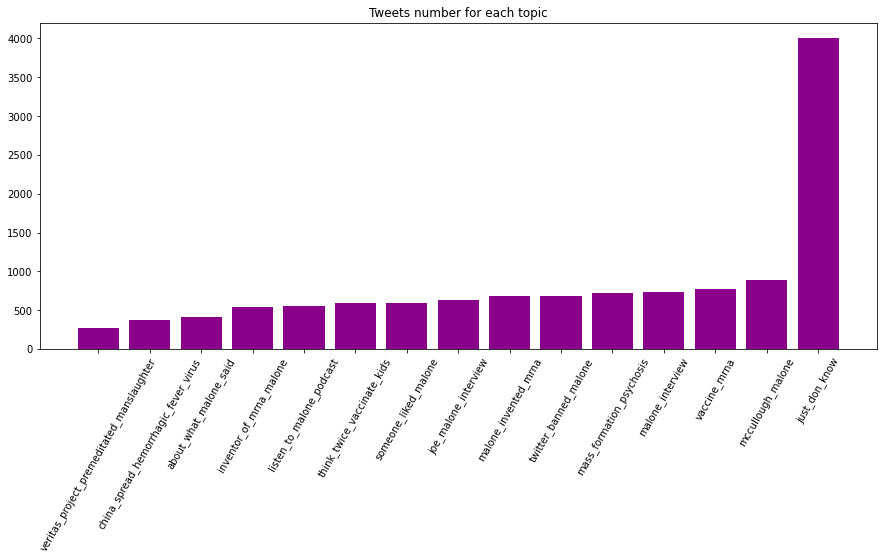

In [376]:
topic_array = np.argmax(tweet_topics_matrix,axis=1)
topic_dic = Counter(topic_array)
topic_dic = sorted(topic_dic.items(), key=lambda x:x[1],reverse = False)
topic_dic = dict(topic_dic)

plt.figure(figsize= (15,6))
plt.bar(range(len(topic_dic.keys())),topic_dic.values(),
        tick_label =np.array(tweet_topics_list)[list(topic_dic.keys())], color = 'darkmagenta' )
plt.xticks(rotation = 60)
plt.title("Tweets number for each topic")



In [381]:
### print tweets closest to the topics
print_n =2
last_n =10
print(len( topic_dic.keys()))
for i in topic_dic.keys():
    topic = tweet_topic_df_nmf.columns[i]
    print(f'Topic number {i} :\033[1m{topic}\033[0m',)
    print(f"Top words are {output[3][i]}\n")
    for i,index in enumerate(tweet_topic_df_nmf[topic].argsort()[-last_n:-print_n- last_n:-1]):
        print(i,":",df_tweet.tweet_corpus.iloc[index],"")
    print(" "*15,"*"*88,'\n')
    

15
Topic number 6 :veritas_project_premeditated_manslaughter
Top words are veritas, project, project veritas, manslaughter, premeditated, highest, premeditated manslaughter, highest levels, levels, manslaughter millions, millions, coordinated, millions people, coordinated highest, wolf, people coordinated, naomi, naomi wolf, bombshell, people

0 :  premeditated manslaughter of millions of people coordinated at the highest levels naomi wolf and dr malone respond to project veritas bombshell video wtf  
1 :  premeditated manslaughter of millions of people coordinated at the highest levels naomi wolf and dr malone respond to project veritas bombshell video  unbelievable  
                **************************************************************************************** 

Topic number 3 :china_spread_hemorrhagic_fever_virus
Top words are china, virus, ebola, hemorrhagic, fever, hemorrhagic fever, ebola like, like hemorrhagic, fever virus, spreading, spreading china, disease, disease 

### Combine data frame for downstream visualiation

In [316]:
# print sample tweets for each topics
df_tweet_topic_print = pd.DataFrame([df_tweet.tweet_corpus.values,topic_array,np.array(tweet_topics_list)[topic_array]]).transpose()
df_tweet_topic_print.columns = ['tweet','topic_number','topic']
df_tweet_topic_print.head()

,tweet,topic_number,topic
0,dr malone the government is now lawless,14,just_don_know
1,“how prevents melatonin significantly reduces ...,8,think_twice_vaccinate_kids
2,i would really love to see you debate dr malo...,14,just_don_know
3,hmmm have you listened to the interviews ith ...,4,mccullough_malone
4,yes dr malone is solid brilliant deeply infor...,14,just_don_know


In [317]:
# for i in topic_dic.keys():
#     df_temp = df_tweet_topic_print[df_tweet_topic_print.topic_number ==i]
#     print(f'Topic number {i}:  \033[1m{tweet_topics_list[i]}\033[0m \n')
#     print(f'\033[1m Topic words:\033[0m {output[3][i]} \n')
#     x = random.sample(df_temp.tweet.to_list(),min(10,len(df_temp)))
#     for j,des in enumerate(x):
#         print(f"{j}:",des,'\n')
#     print(" "*15,"*"*88,'\n')

In [318]:
df_tp_combine = df_tweet_topic_print.join(df_user_topic_print)
df_tp_combine['senti_score'] = df_tweet.sentiment_score
df_tp_combine['author_followers'] =df_tweet['author_followers']
df_tp_combine['author_followings'] = df_tweet['author_followings']
df_tp_combine['author_tweets']  = df_tweet['author_tweets']
df_tp_combine['retweets'] = df_tweet['retweets']
df_tp_combine['replies'] = df_tweet['replies']
df_tp_combine['likes'] = df_tweet['likes']
df_tp_combine['quote_count'] = df_tweet['quote_count']

In [319]:
df_tp_combine.tail()

,tweet,topic_number,topic,description,descpt_topic_number,descpt_topic,senti_score,author_followers,author_followings,author_tweets,retweets,replies,likes,quote_count
12418,malone literally said this on the joe rogan p...,10,about_what_malone_said,"maori mumma bear, living in oz who 💜 all thing...",11,what_people_like_and_about_time,0.0000,506.0,1155.0,31785.0,0.0,1.0,0.0,0.0
12419,well it’s really not a vaccine it’s an unappr...,12,vaccine_mrna,"i block all trolls, which includes those seeki...",11,what_people_like_and_about_time,0.0000,873.0,165.0,181530.0,0.0,1.0,0.0,0.0
12420,dr malone would agree with that as well yet ...,13,twitter_banned_malone,"for to us a child is born, to us a son is give...",3,god_family_country,-0.8439,60.0,59.0,1906.0,1.0,1.0,1.0,0.0
12421,this is from msm dr malone been talking about...,14,just_don_know,"father and dolphin fanatic, cub lifer, and por...",7,father_husband_identity,0.7988,70.0,310.0,2852.0,0.0,2.0,0.0,0.0
12422,pat we are over the target if they take down y...,7,malone_interview,seer🔮seeker🔭sayer🌬📢sage🧘‍♀️yoga🌲nature🌹🐈lmt/nm...,2,truthseeker,-0.1606,1634.0,4284.0,52540.0,0.0,1.0,4.0,0.0


In [320]:
with open('df_tp_combine.pkl','wb')as file:
    pickle.dump(df_tp_combine,file)

In [321]:
df_analy = df_user_tweet_senti.groupby(['topic_number','descpt_topic_number'],
                            as_index = True).agg( {'senti_score':['mean','std'], 
                                                     'tweet':'count'}).reset_index()
df_analy.columns = ['topic_number','descpt_topic_number','senti_score_mean','senti_score_mean','tweet_count']

####  Visualization top modeling result

In [322]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure,show
#from bokeh.models import Label
from bokeh.io import output_notebook
# tSNE Dimension Reduction

In [323]:
tsne_model = TSNE(n_components=2, random_state=0,verbose=2)
tsne_tweet_NMF = tsne_model.fit_transform(tweet_topics_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12423 samples in 0.103s...
[t-SNE] Computed neighbors for 12423 samples in 3.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12423
[t-SNE] Computed conditional probabilities for sample 2000 / 12423
[t-SNE] Computed conditional probabilities for sample 3000 / 12423
[t-SNE] Computed conditional probabilities for sample 4000 / 12423
[t-SNE] Computed conditional probabilities for sample 5000 / 12423
[t-SNE] Computed conditional probabilities for sample 6000 / 12423
[t-SNE] Computed conditional probabilities for sample 7000 / 12423
[t-SNE] Computed conditional probabilities for sample 8000 / 12423
[t-SNE] Computed conditional probabilities for sample 9000 / 12423
[t-SNE] Computed conditional probabilities for sample 10000 / 12423
[t-SNE] Computed conditional probabilities for sample 11000 / 12423
[t-SNE] Computed conditional probabilities for sample 12000 / 12423
[t-SNE] Computed conditional probabilities for sam

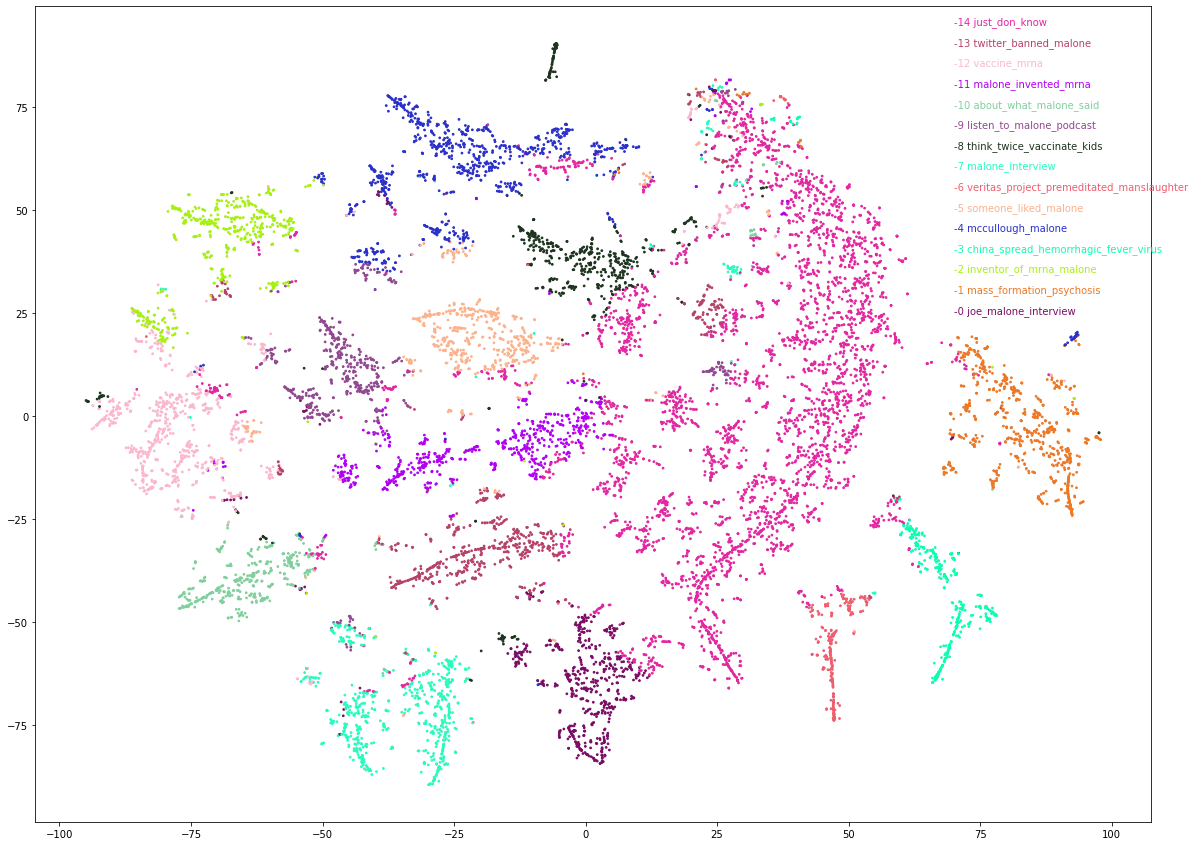

In [349]:
# Plot the Topic Clusters using Bokeh
from random import randint
n_topics = n_components
color = []


for i in range(n_topics):
    color.append('#%06X' % randint(0, 0xFFFFFF))


#show(plot)

# color=['#373734',
#  '#0D5E73',
#  '#6E1FF3',
#  '#8C181F',
#  '#712038',
#  '#90CA26',
#  '#F45D0C',
#  '#BA02AE',
#  '#EEEF83',
#  '#D89B46',
#  '#5C9B20',
#  '#777FBA',
#  '#7D1555',
#  '#63CF41',
#  '#70977C']
    
    
fig, ax = plt.subplots(figsize= (20,15))
ax.scatter(x=tsne_tweet_NMF[:,0], y=tsne_tweet_NMF[:,1], color=np.array(color)[topic_array],s = 3)

for i in topic_dic:

    ax.annotate(f"-{i} "+tweet_topics_list[i], (70,25+5*i),color = color[i])


### LDA analysis

In [325]:
# n_components = 8 
# corpus = matutils.Sparse2Corpus(doc_term_matrix_tfidf.transpose())
# id2word = dict((v, k) for k, v in tfidf.vocabulary_.items()) 
# lda = models.LdaModel(corpus=corpus, num_topics=n_components, id2word=id2word)

# topic_weights = []
# for i, row_list in enumerate(lda[corpus]):
#     topic_weights.append([w for i, w in row_list])

# # Array of topic weights    
# arr = pd.DataFrame(topic_weights).fillna(0).values

# # Dominant topic number in each doc
# topic_num = np.argmax(arr, axis=1)


# tweet_topic_list_lda =[f'Topic_{i}' for i in range(n_components)]

# topic_array_lda = topic_num
# topic_dic_lda = Counter(topic_array)

# plt.figure(figsize= (15,6))
# plt.bar(topic_dic_lda.keys(),topic_dic_lda.values(),
#         tick_label =np.array(tweet_topic_list_lda)[list(topic_dic_lda.keys())], color = 'lightblue' )
# plt.xticks(rotation = 45)
# plt.title("Tweets number for each topic")


# df_tweet_topic_print_lda = pd.DataFrame([df_tweet.tweet_corpus,topic_array_lda,np.array(tweet_topic_list_lda)[topic_array_lda]]).transpose()
# df_tweet_topic_print_lda.columns = ['tweet','topic_number','topic']


# for i in range(len(tweet_topic_list_lda)):
#     df_temp = df_tweet_topic_print[df_tweet_topic_print_lda.topic_number ==i]
#     df_temp.drop_duplicates(subset= 'tweet',inplace= True)
#     print(f'Topic number {i}:  \033[1m{tweet_topic_list_lda[i]}\033[0m \n')
#     tweets_print= df_temp.tweet.tolist()
#     for j in range(5):
#         x = randint(0,len(tweets_print))
#         print(f"{j}: ",tweets_print[x] )
#     print(" "*15,"*"*88,'\n')

In [326]:
# # tSNE Dimension Reduction
# tsne_model = TSNE(n_components=2,random_state=0,verbose=2)
# tsne_lda = tsne_model.fit_transform(arr)
# # Plot the Topic Clusters using Bokeh
# from random import randint
# n_topics = n_components
# color = []


# for i in range(n_topics):
#     color.append('#%06X' % randint(0, 0xFFFFFF))


# #show(plot)

# # color =['#DF5C58',
# #  '#6784D5',
# #  '#D86CBD',
# #  '#36D5BE',
# #  '#81AA4F',
# #  '#9D6EDF',
# #  '#9FCA60',
# #  '#205016']
# # plt.figure(figsize= (15,10))
# # plt.scatter(x=tsne_tweet_NMF[:,0], y=tsne_tweet_NMF[:,1], color=np.array(color)[topic_array],s = 3)
# # for i in topic_dic:
# #     print(i,tweet_topics_list[i])
# #     ax.annotate(tweet_topics_list[i], (1,10))
    
    
# fig, ax = plt.subplots(figsize= (20,15))
# ax.scatter(x=tsne_tweet_NMF[:,0], y=tsne_tweet_NMF[:,1], color=np.array(color)[topic_array],s = 3)

# for i in topic_dic:

#     ax.annotate(f"-{i} "+tweet_topics_list[i], (60,25+5*i),color = color[i])

### corEx

In [327]:
# words = cv.get_feature_names()
# n_hidden = 8
# corex_topic_model = ct.Corex(n_hidden= n_hidden, ### YOUR NUMBER OF TOPICS HERE
#                        words=words,  ### YOUR VOCABULARY HERE
#                        seed=1
#                        )
# corex_topic_model.fit(doc_term_matrix_cv,          ### YOUR DOCUMENT TERM MATRIX HERE
#                 words= words,      ### YOUR VOCABULARY HERE
#                 docs= df_tweet.tweet_corpus,  ### YOUR DOCUMENT SERIES HERE
#                 anchors=[['mccullough'],['kids']], 
#                 anchor_strength= 10      
#                 )
# topics = corex_topic_model.get_topics()
# for n,topic in enumerate(topics):
#     topic_words,_,_ = zip(*topic)
#     print(f'{n}: {", ".join(topic_words)}')
# plt.figure(figsize=(15,6))
# plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs)
# plt.xlabel('Topic')
# plt.ylabel('Total Correlation');

# Clustering

In [328]:
#df_clustering = pd.concat([descrip_topic_df_nmf,tweet_topic_df_nmf,df_tweet.sentiment_score/10],axis=1)
#df_clustering = pd.concat([descrip_topic_df_nmf,tweet_topic_df_nmf],axis=1)
df_clustering = pd.concat([tweet_topic_df_nmf,df_tweet.sentiment_score/100],axis=1)

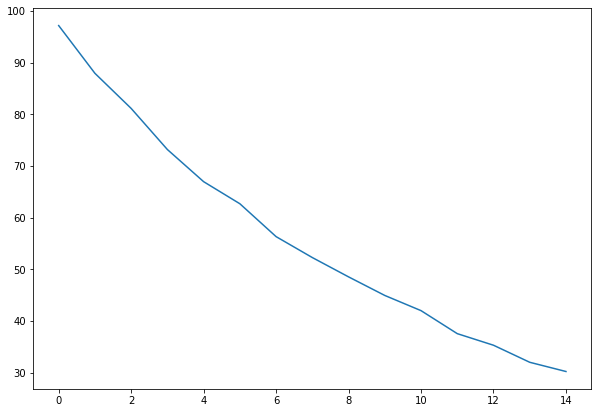

In [329]:
inertia = []
for num_clusters in range(1,16):
    km = KMeans(n_clusters=num_clusters) 
    km.fit(df_clustering) 
    inertia.append(km.inertia_)
plt.figure(figsize= (10,7))
plt.plot(inertia)

In [330]:
n_clusters =15
km = KMeans(n_clusters=n_clusters) 
km.fit(df_clustering) 

KMeans(n_clusters=15)

In [331]:
centroid_dist = cosine_distances(km.cluster_centers_,df_clustering.values )

In [352]:
cluster_dic = Counter(km.labels_)
cluster_dic

Counter({11: 4985,
         2: 1984,
         8: 495,
         6: 655,
         4: 593,
         7: 587,
         0: 455,
         14: 475,
         3: 746,
         1: 512,
         13: 298,
         9: 69,
         12: 295,
         5: 217,
         10: 57})

In [351]:
closest_point = []
for n in range(km.n_clusters):

    closest_point.append( (centroid_dist[n].argsort())[:5])
    
for i,arr in enumerate(closest_point):

    print(f"Cluster {i}:\n")
    for j in arr:
        print("Topic",topic_array[j],"-" ,np.array(tweet_topics_list)[topic_array][j],"- sentiment score",
              df_tweet.sentiment_score.iloc[j],":\n",
              df_tweet.tweet_corpus.iloc[j])
    print("*"*88)


Cluster 0:

Topic 9 - listen_to_malone_podcast - sentiment score 0.0 :
 don t listen to rogan or dr malone but do listen to this racheal madcow impersonator 
Topic 9 - listen_to_malone_podcast - sentiment score 0.296 :
  then you didn’t listen to the entire three hour podcast dr malone clearly exposes it in the discussion 
Topic 9 - listen_to_malone_podcast - sentiment score -0.2263 :
  i m just here to sip on your tears as i listen to the dr malone podcast with rogan for the 5th time 
Topic 9 - listen_to_malone_podcast - sentiment score -0.5707 :
  listen to dr malone on pbd podcast  it goes waaay deeper than rogan podcast way deep it s sickening what these scientists ceo s media are doing an have been doing behind our backs wake the f up 
Topic 9 - listen_to_malone_podcast - sentiment score 0.8313 :
  podcast 1718 is one of the best podcast rogan did you should give it a listen 1757 with dr malone is another top 5 highly recommend you listen with an open mind 
***********************

In [334]:

tsne_model = TSNE(n_components=2, random_state=0,verbose=2)
tsne_clustering = tsne_model.fit_transform(centroid_dist.transpose())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12423 samples in 0.011s...
[t-SNE] Computed neighbors for 12423 samples in 2.463s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12423
[t-SNE] Computed conditional probabilities for sample 2000 / 12423
[t-SNE] Computed conditional probabilities for sample 3000 / 12423
[t-SNE] Computed conditional probabilities for sample 4000 / 12423
[t-SNE] Computed conditional probabilities for sample 5000 / 12423
[t-SNE] Computed conditional probabilities for sample 6000 / 12423
[t-SNE] Computed conditional probabilities for sample 7000 / 12423
[t-SNE] Computed conditional probabilities for sample 8000 / 12423
[t-SNE] Computed conditional probabilities for sample 9000 / 12423
[t-SNE] Computed conditional probabilities for sample 10000 / 12423
[t-SNE] Computed conditional probabilities for sample 11000 / 12423
[t-SNE] Computed conditional probabilities for sample 12000 / 12423
[t-SNE] Computed conditional probabilities for sam

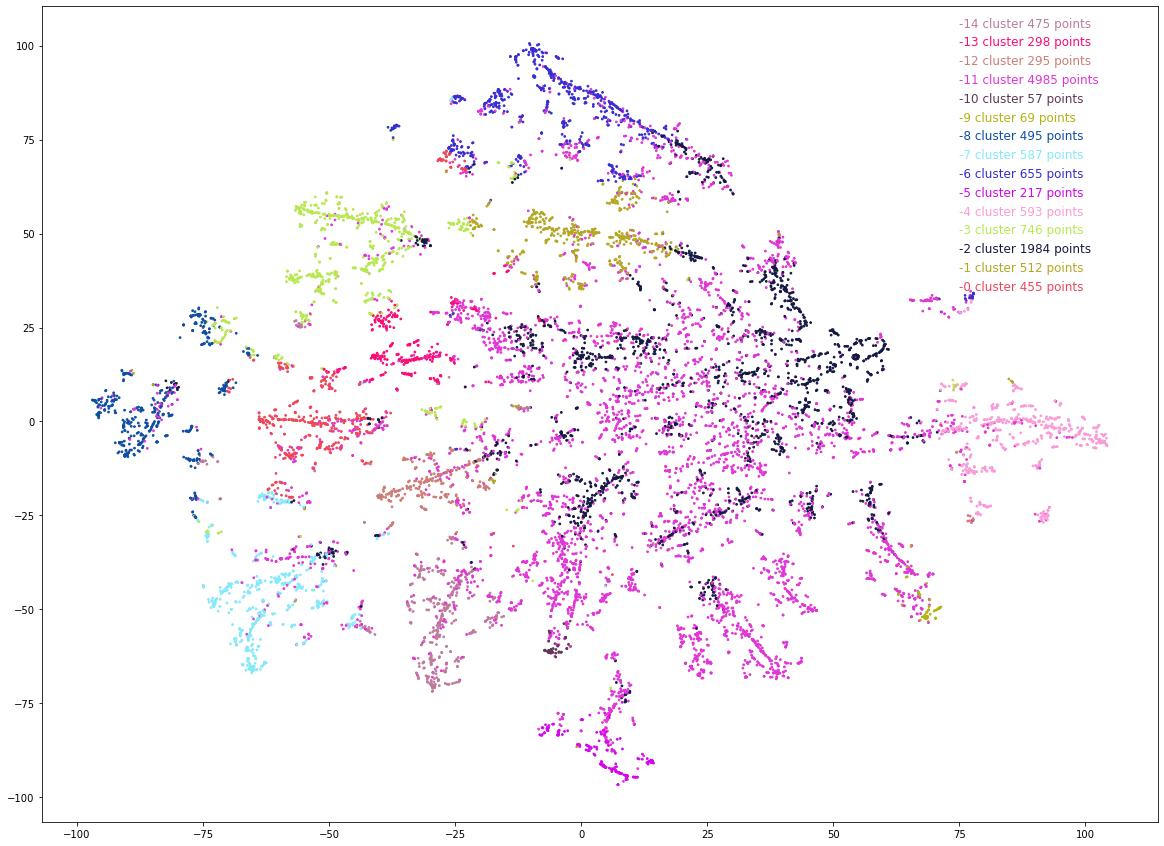

In [353]:
## Plot the Topic Clusters using Bokeh
from random import randint
n_topics = n_clusters
color = []


for i in range(n_topics):
    color.append('#%06X' % randint(0, 0xFFFFFF))


#show(plot)

# color =['#DF5C58',
#  '#6784D5',
#  '#D86CBD',
#  '#36D5BE',
#  '#81AA4F',
#  '#9D6EDF',
#  '#9FCA60',
#  '#205016']
# plt.figure(figsize= (15,10))
# plt.scatter(x=tsne_tweet_NMF[:,0], y=tsne_tweet_NMF[:,1], color=np.array(color)[topic_array],s = 3)
# for i in topic_dic:
#     print(i,tweet_topics_list[i])
#     ax.annotate(tweet_topics_list[i], (1,10))
    
    
fig, ax = plt.subplots(figsize= (20,15))

ax.scatter(x=tsne_clustering[:,0], y=tsne_clustering[:,1],
           color=np.array(color)[km.labels_],s = 3)

for i in range(n_clusters):

    ax.annotate(f"-{i} cluster {cluster_dic[i]} points", (75,35+5*i),color = color[i],fontsize=12)